# Feedback Amplifier

> Refs:
> * Introduction to Radio Frequency Design, Wes Hayward [Pages 18-26]

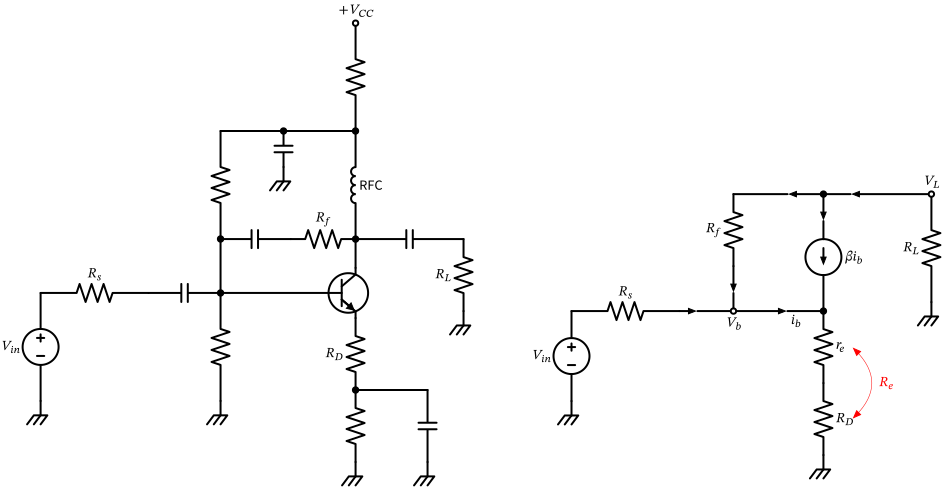

In [100]:
import math

import ipywidgets as widgets
import numpy as np
import pint
import plotly.graph_objects as go
import plotly.io as pio
import schemdraw as schem
import schemdraw.elements as e
from eseries import E12, E24, E48, erange, find_nearest
from ipywidgets import Layout, interact, interact_manual
from schemdraw import dsp  # , flow

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Support rendering plots in github
pio.renderers.default = "jupyterlab+png"
schem.use("svg")

ureg = pint.UnitRegistry()
layout = Layout(width="auto")
style = {"description_width": "50px"}

###############################################################


def draw_fba():
    d = schem.Drawing()

    d += e.GroundChassis()
    d += e.SourceV().up().length(3).label("$V_{in}$")
    d += e.Resistor().label("$R_s$").right().length(3)
    d += e.Capacitor().length(2)
    d += e.Dot()
    d.push()
    d += e.Resistor().down()
    d += e.GroundChassis()
    d.pop()
    d.push()
    d += e.Line().length(1.5).up()
    d += e.Dot()
    d += e.Resistor().up()
    d += e.Line().right().length(1.75)
    d += e.Dot()
    d.push()
    d += e.Capacitor().down().length(1)
    d += e.GroundChassis()
    d.pop()
    d += e.Line().length(2)
    d += e.Dot()

    d.pop()
    d += e.Line().right()
    d += (TR1 := e.BjtNpn(circle=True))

    d += e.Line().up().at(TR1.collector).length(0.8)
    d += e.Dot()
    d.push()
    d += e.Resistor().label("$R_f$").left().length(1.8)
    d += e.Capacitor().length(2)
    d.pop()
    d.push()
    d += e.Inductor().label("RFC", loc="bot").up()
    d += e.Resistor().length(3)
    d += e.Dot(open=True).label("$+V_{CC}$")

    d.pop()
    d += e.Capacitor().right()
    d += (RL := e.Resistor().down().label("$R_L$").length(2))
    d += e.GroundChassis()

    d += e.Resistor().label("$R_D$").down().at(TR1.emitter).length(2)
    d += e.Dot()
    d.push()
    d += e.Resistor().down().length(2)
    d += e.GroundChassis()
    d.pop()
    d += e.Line().right().length(2)
    d += e.Capacitor().down().length(2)
    d += e.GroundChassis()

    ########################
    # small-signal equiv:-
    d += e.Gap().at(RL.end).right()
    d.push()
    d += e.SourceV().label("$V_{in}$").down().reverse().length(2.5)
    d += e.GroundChassis()
    d.pop()
    d += e.Resistor().label("$R_s$").right().length(3)
    d += e.Arrow().length(0.5)
    d += e.Line().length(1)
    d += e.Dot(open=True).label("$V_b$", loc="bot")
    d += e.Arrow().label("$i_b$", loc="end").length(1.5)
    d += e.Line().length(1)
    d += e.Dot()
    d.push()

    d += (re := e.Resistor().label("$r_e$", loc="bot").down().length(2))
    d += (RD := e.Resistor().label("$R_D$", loc="bot").down().length(2))
    d += e.GroundChassis()

    d += (
        e.Arc2(arrow="<->", radius=0.6, color="red")
        .linewidth(0.5)
        .at(re.center, dx=0.8, dy=0)
        .to(RD.center, dx=0.8, dy=0)
        .label("$R_e$", ofst=(0.25, 0))
    )

    d.pop()
    d += e.Line().up().length(1)
    d += e.SourceI().reverse().up().label("$\\beta i_b$", loc="bot").length(1)
    d += e.Line().length(0.5)
    d += e.Arrow().reverse().length(0.75)
    d += e.Dot()
    d.push()
    d += e.Arrow().left().length(1)
    d += e.Line().length(1.5)
    d += e.Resistor().label("$R_f$").down().length(2)
    d += e.Arrow().length(0.75)
    d += e.Line().length(0.5)

    d.pop()
    d += e.Line().length(0.75).right()
    d += e.Arrow().reverse().length(2.25)
    d += e.Dot(open=True).label("$V_L$")
    d += e.Resistor().label("$R_L$").down()
    d += e.GroundChassis()

    return d


draw_fba().draw()